<font face = "Times New Roman">

<h1> Regression and Error Analysis of Thick Disk</h1>
<h2> Preet Patel</h2>
<hr>
<font size = 3>In this project, I aim to use linear regression in a real data set for a simulated Milky-Way like galaxy. For the purpose of investigating the thick disk, we identify a bimodality in the metallicities of stars found throughout the galaxy. These two separate tracks represent the thin and thick disks of the galaxy.

Observations show that this bimodality exists in our own Milky Way, and a good portion of other spiral galaxies as well. 

<img src = "100Bins.gif">
<center><font size = 2> Gif of the tracks evolving with galactic radii.</font></center>

I plot these stars in terms of [Fe/H] vs. [O/Fe] in a 2Dhistgram or scatter plot for varying "boxes" or "cylinders" around the galactic center. This will result in different plots (as shown above, in 0.1 kpc steps from the galactic center). However, if we isolate the top track and find the slope of a regression line through it, the line should have a relatively constant slope at all galactic radii. If so, this would mean that the stars in this region formed along the same track and perhaps came from the same place.

The aim of this project is to investigate whether or not this is the case.

In [11]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})

%matplotlib inline
import numpy as np
import pylab
from pylab import figure, axes, pie, title, show
from scipy import optimize, stats
import emcee
import corner
import h5py

<font face = "Times New Roman">
Loading all relevant files. Note: May take a little while. 

In [12]:
data = h5py.File('m12i_data.hdf5', 'r')

In [13]:
#distances = np.loadtxt("distances.txt")
#ofe = np.loadtxt("ofe.txt")
#feh = np.loadtxt("feh.txt")

In [14]:
distances = data['main']['distances']
ofe = data['main']['ofe']
feh = data['main']['feh']

In [15]:
x = distances[:,0]
y = distances[:,1]
z = distances[:,2]

print(len(x))
print(len(y))
print(len(z))

x = np.array(x)
y = np.array(y)
z = np.array(z)

r = np.sqrt(x**2+y**2) #this is the Galactocentric radius in cylindrical coordinates - R in the plane of the disk

1385246
1385246
1385246


<font face = "Times New Roman">
Now I create a solar cylinder where we can look at a slice of the galaxy and metallicities of stars within.

In [16]:
ind = np.where((r >= 5) & (r < 7) & (z >=-3) & (z <= 3))
rsc = r[ind] #sc just means solar cylinder
zsc = z[ind]
fehsc = feh[ind] #these are the iron abundance values for just the stars in the Solar Cylinder
ofesc = ofe[ind] #this is the alpha abundance for just the stars in the Solar Cylinder

<font face = "Times New Roman">
The "by eye" slope estimate is approximately -0.06 with an intercept of 0.3. This is what we aim to empirically confirm for varying radii.


Taking an arbitrary cut so we can just look at the thick disk region, we eliminate the data points that are below this cut.

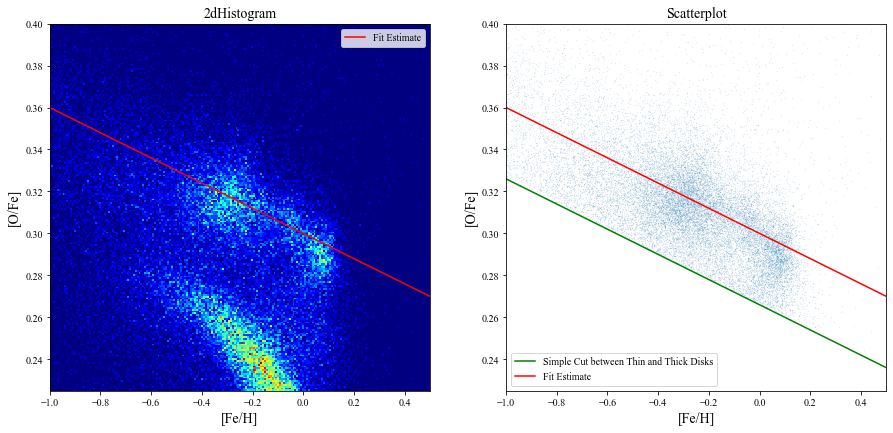

In [17]:
nbins= 200
m = -0.06 # Guess for slope
b = 0.266

xarr = np.linspace(-1,0.5)
yarr = m*xarr + b
slopearr = m*xarr + 0.3
mask = ofesc > m*fehsc + b

fig = plt.figure(figsize=(14,6))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.2,
                     bottom=0.1, top=0.95, hspace=0.15)

ax = fig.add_subplot(121)
ax.hist2d(fehsc, ofesc, bins=nbins, cmap = 'jet', range=[[-1,.5],[0.225,0.4]])
ax.set_xlim(-1,.5)
ax.set_ylim(.225, .4)
ax.plot(xarr, slopearr, color='r', label = "Fit Estimate")
ax.legend()
ax.set_xlabel("[Fe/H]", size = 14)
ax.set_ylabel("[O/Fe]", size = 14)
ax.set_title("2dHistogram", size = 14)

ax2 = fig.add_subplot(122)
ax2.scatter(fehsc[mask],ofesc[mask], marker = '.', s = 0.01)
ax2.set_xlabel("[Fe/H]", size = 14)
ax2.set_ylabel("[O/Fe]", size = 14)
ax2.set_title("Scatterplot", size = 14)
ax2.set_xlim(-1, 0.5)
ax2.set_ylim(0.225, 0.4)
ax2.plot(xarr, yarr, color='g', label = "Simple Cut between Thin and Thick Disks")
ax2.plot(xarr, slopearr, color='r', label = "Fit Estimate")

plt.legend()
plt.show()

<font face = "Times New Roman">
We now define our $\chi ^2$ function. The reason I chose $\chi^2$ is because the error in this dataset can be ignored as it is gathered from a simulation. There is no "error" in terms of $\sigma_{x}$ or $\sigma_{y}$, keeping the values smaller than the slope and constant will allow for each point to be weighed equally. 

I model the function after:

$$ \chi^2(a,b) = \sum_i^{N-1} \left({y_i - a - bx_i \over \sigma}\right)^2 - Nlog\Delta y $$

(From Numerical recipes, 15.1)


Noting that $N$, $\sigma$, and $\Delta y$ are constant, thereby making the function:

$$ \sum_{i=0}^{N-1} \left({{y_i - a - bx_i}}\right)^2 $$

To confirm the notion of a linear relationship...
Pearson  r = -0.717  probability of no correlation = 0.0e+00
O DATA: 
       fun: 11.72454287985163
 hess_inv: array([[3.78122521e-05, 4.80156558e-05],
       [4.80156558e-05, 1.34566937e-04]])
      jac: array([0.00029516, 0.00011969])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 128
      nit: 3
     njev: 39
   status: 2
  success: False
        x: array([ 0.29897404, -0.05778085])
da = 0.006149166783662036
db = 0.011600299010378552
Regression values: a = 0.2990 +- 0.0061  b = -0.0578 +- 0.0116
Guessed values:    a = 0.3               b = -0.06


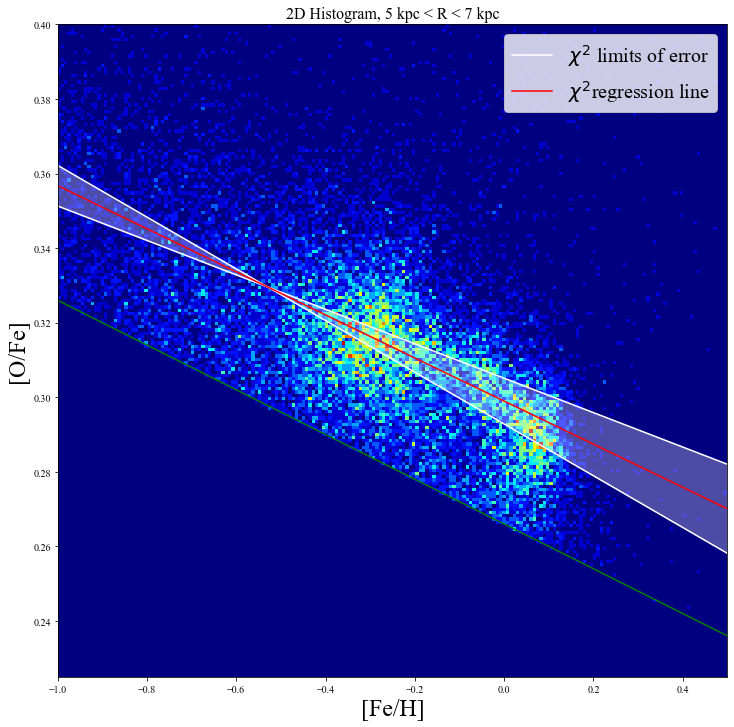

In [18]:
x = fehsc[mask]
y = ofesc[mask]

dy = 0.01

r, p = stats.pearsonr(x, y)

print('To confirm the notion of a linear relationship...')
print('Pearson  r = %.3f  probability of no correlation = %.1e' % (r, p))

def chi2(p):
    return np.sum(np.square((y-p[0]-p[1]*x)))

o = optimize.minimize(chi2, [0.3,-0.6])
da = np.sqrt(o.hess_inv[0,0])
db = np.sqrt(o.hess_inv[1,1])

print('O DATA: \n',o)
print('da =',da)
print('db =',db)

m = o.x[1]
a = o.x[0]
slopearr2 = m*xarr + a

print('Regression values: a = %.4f +- %.4f  b = %.4f +- %.4f' % \
  (o.x[0], np.sqrt(o.hess_inv[0,0]), o.x[1], np.sqrt(o.hess_inv[1,1])))
print('Guessed values:    a = 0.3               b = -0.06')

plt.figure(figsize = (12,12))
plt.xlabel("[Fe/H]", size = 24)
plt.ylabel("[O/Fe]", size = 24)
plt.title("2D Histogram, 5 kpc < R < 7 kpc", size = 16)
plt.xlim(-1, 0.5)
plt.ylim(0.225, 0.38)
plt.plot(xarr, yarr, color='g')

plt.hist2d(fehsc[mask], ofesc[mask], bins=nbins, cmap = 'jet', range=[[-1,.5],[0.225,0.4]])
plt.plot(xarr, (m+db)*xarr + a+da, color='w')
plt.plot(xarr, (m-db)*xarr + a-da, color='w', label = r'$\chi^2$' + " limits of error")
plt.fill_between(xarr, (m+db)*xarr + a+da,(m-db)*xarr + a-da, color='w', alpha = 0.3)
plt.plot(xarr, slopearr2, color='r', label = r'$\chi^2$' + "regression line")


plt.legend(fontsize = 20)
plt.show()

<font face = "Times New Roman">
We see that linear regression has found a slope very similar to our "by-eye" estimate. We now iterate this over varying galactic radii and height. In the research, the radii and heights above the galactic plane that we were interested were:

$$R \in ([5,7],[7,9],[9,11]),$$  and 
$$Z \in ([0,0.5],[0.5,1],[1,2])$$

so we examine exactly that.

Slope for R: 5 to 7 | Z:  0 to 0.5 | is -0.05795988521254529 +- 0.032547602181735226
Slope for R: 7 to 9 | Z:  0 to 0.5 | is -0.060134756611838605 +- 0.04669733724695571
Slope for R: 9 to 11 | Z:  0 to 0.5 | is -0.05562842292604542 +- 0.0697630693638312
Slope for R: 5 to 7 | Z:  0.5 to 1 | is -0.05668417921532361 +- 0.035461714224691264
Slope for R: 7 to 9 | Z:  0.5 to 1 | is -0.05968121020405817 +- 0.0499781800464683
Slope for R: 9 to 11 | Z:  0.5 to 1 | is -0.060057822737001054 +- 0.8802402210843461
Slope for R: 5 to 7 | Z:  1 to 2 | is -0.05602151944775957 +- 0.03062902925698563
Slope for R: 7 to 9 | Z:  1 to 2 | is -0.05623000734081823 +- 0.042273180114743444
Slope for R: 9 to 11 | Z:  1 to 2 | is -0.05214816837730729 +- 0.8354500028982996


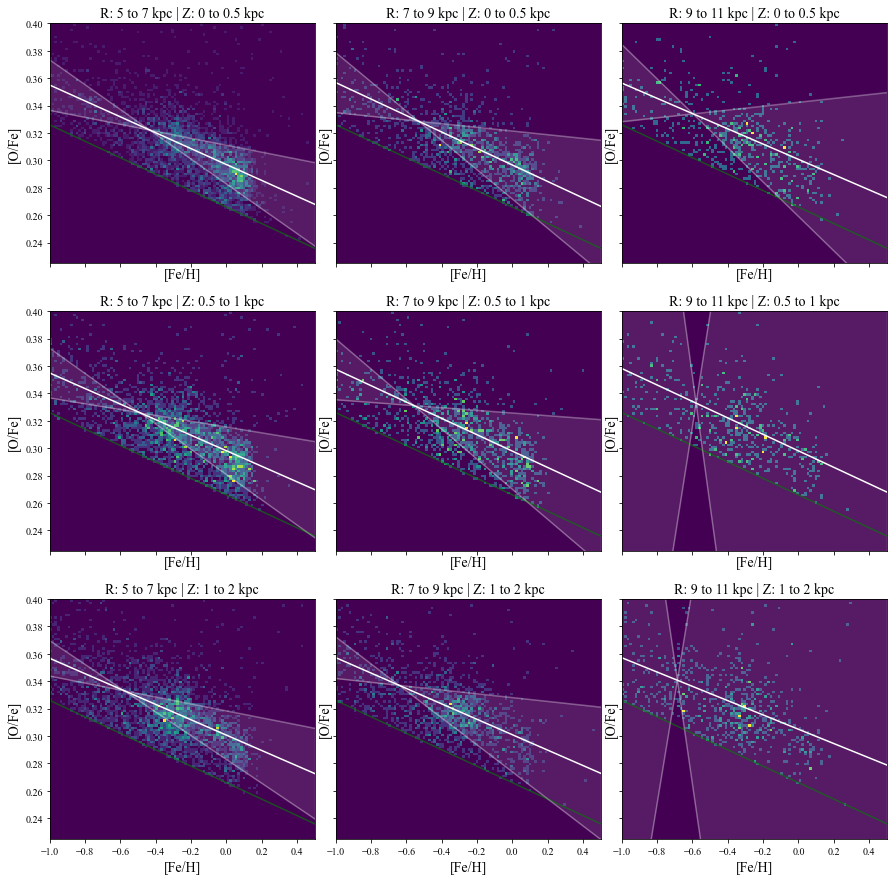

In [19]:
x = distances[:,0]
y = distances[:,1]
z = distances[:,2]

x = np.array(x)
y = np.array(y)
z = np.array(z)

r = np.sqrt(x**2+y**2) #this is the galactocentric radius in cylindrical coordinates - R in the plane of the disk

r1 = 5
z_arr = [0,0.5,1,2]

m_array = []
dm_array = []
a_array = []
da_array = []
fehscs = []
ofescs = []

fig, axs = plt.subplots(3,3, figsize = (15,15), edgecolor='k',sharex='col', sharey='row')
fig.subplots_adjust(wspace=0.08, hspace=0.2)

axs = axs.ravel()


counter = 0
for i in range(0,3):
    r1 = 5
    for j in range(0,3):
        ind = np.where((r >= r1) & (r < r1+2) & (z >= z_arr[i]) & (z <= z_arr[i+1]))
        rsc = r[ind] #sc just means solar cylinder
        zsc = z[ind]
        fehsc = feh[ind] #this is the iron values for just the stars in the Solar Cylinder
        ofesc = ofe[ind] #this is the alpha abundance for just the stars in the Solar Cylinder

        nbins= 200
        m = -0.06 # Guess for slope
        b = 0.266

        xarr = np.linspace(-1,0.5)
        yarr = m*xarr + b
        slopearr = m*xarr + 0.3
        mask = ofesc > m*fehsc + b

        x = fehsc[mask]
        y = ofesc[mask]
        
        fehscs.append(x)
        ofescs.append(y)

        dy = 0.01

        def chi2(p):
            return np.sum(np.square((y-p[0]-p[1]*x)))

        o = optimize.minimize(chi2, [0.3,-0.6])
        a_array.append(o.x[0])
        m_array.append(o.x[1])
        da_array.append(np.sqrt(o.hess_inv[0,0]))
        dm_array.append(np.sqrt(o.hess_inv[1,1]))
        
        print("Slope for R:", r1, "to", r1+2, "| Z: ", z_arr[i], "to", z_arr[i+1], "| is", o.x[1], "+-", np.sqrt(o.hess_inv[1,1]))
        axs[counter].hist2d(x,y, bins = 100, range=[[-1,.5],[0.225,0.4]])
        axs[counter].plot(xarr, yarr, color='g', alpha = 0.6)
        axs[counter].plot(xarr, o.x[1]*xarr + o.x[0], color = 'w')
        axs[counter].plot(xarr, (o.x[1]+np.sqrt(o.hess_inv[1,1]))*xarr + (o.x[0]+np.sqrt(o.hess_inv[0,0])), 
                          color = 'w', alpha = 0.3)
        axs[counter].plot(xarr, (o.x[1]-np.sqrt(o.hess_inv[1,1]))*xarr + (o.x[0]-np.sqrt(o.hess_inv[0,0])), 
                          color = 'w', alpha = 0.3)
        axs[counter].fill_between(xarr,(o.x[1]+np.sqrt(o.hess_inv[1,1]))*xarr + (o.x[0]+np.sqrt(o.hess_inv[0,0])),
                                  (o.x[1]-np.sqrt(o.hess_inv[1,1]))*xarr + (o.x[0]-np.sqrt(o.hess_inv[0,0])),
                                  color='w', alpha = 0.1)

        axs[counter].set_title("R: " + str(r1) + " to " + str(r1+2) + " kpc | Z: " + \
                               str(z_arr[i]) + " to " + str(z_arr[i+1]) + " kpc", size = 14)
        axs[counter].set_xlabel('[Fe/H]', size = 14)
        axs[counter].set_ylabel('[O/Fe]', size = 14)


        r1 += 2
        counter += 1


<font face = "Times New Roman">
We have obtained our slope values with the relative error for each radius and height! It appears to be relatively constant. 

Now, to be absolutely certain, we will run regression once more on this final dataset to see if a constant slope is what we indeed see. This time, we will include the $Y_{err}$ in our calculations as it is present.

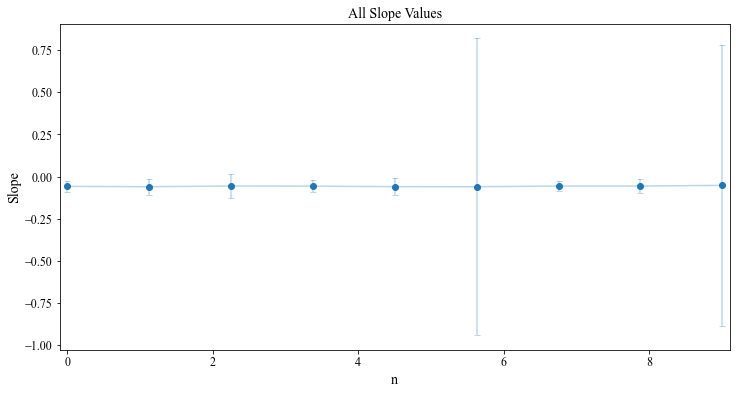

a = -0.0585 +- 0.0178  b = 0.0003 +- 0.0037


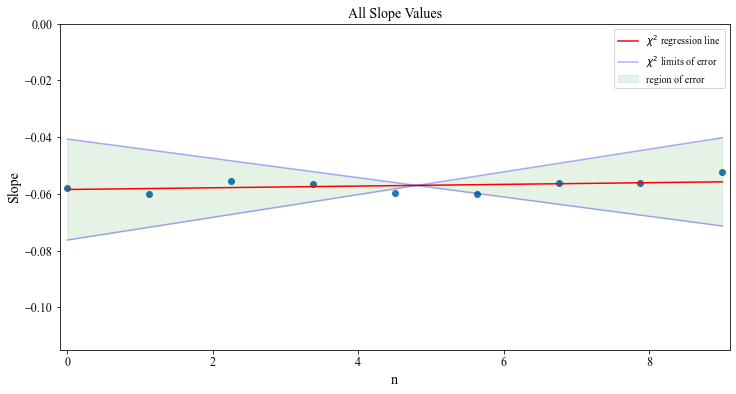

In [20]:
mx_axis = np.linspace(0,len(m_array), len(m_array)) #arbitary axis to plot all of the slopes

plt.figure(figsize = (12,6))

plt.scatter(mx_axis, m_array)
plt.errorbar(mx_axis, m_array, yerr = dm_array, capsize = 3, alpha = 0.3)
plt.title("All Slope Values", size = 14)
plt.ylabel("Slope", size = 14)
plt.xlabel("n", size = 14)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.xlim(-0.1,9.1)
plt.show()

def chi2(p):
    return np.sum(np.square((m_array-p[0]-p[1]*mx_axis)/dm_array))

o = optimize.minimize(chi2, [-1.,1.])

print('a = %.4f +- %.4f  b = %.4f +- %.4f' % \
  (o.x[0], np.sqrt(o.hess_inv[0,0]), o.x[1], np.sqrt(o.hess_inv[1,1])))

a_m = o.x[0]
da_m = np.sqrt(o.hess_inv[0,0])

b_m = o.x[1]
db_m = np.sqrt(o.hess_inv[1,1])

plt.figure(figsize = (12,6))
plt.scatter(mx_axis, m_array)
plt.plot(mx_axis, b_m * mx_axis + a_m, color = 'r', label = r'$\chi^2$' + " regression line")
plt.plot(mx_axis, (b_m+db_m) * mx_axis + (a_m-da_m), color = 'b', label = r'$\chi^2$' + " limits of error", alpha = 0.3)
plt.plot(mx_axis, (b_m-db_m) * mx_axis + (a_m+da_m), color = 'b', alpha = 0.3)
plt.fill_between(mx_axis, (b_m+db_m) * mx_axis + (a_m-da_m), (b_m-db_m) * mx_axis + (a_m+da_m), color = 'g', alpha = 0.1, 
                 label="region of error")
plt.xlim(-0.1,9.1)
plt.legend()
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title("All Slope Values", size = 14)
plt.ylabel("Slope", size = 14)
plt.xlabel("n", size = 14)
plt.ylim(-.115,0)
plt.show()

<font face = "Times New Roman">
The error on the slope is relatively large (likely due to fewer stars at larger galactic radii, which leads to a greater $y_{err}$), however it includes a value of 0 in less than a single standard deviation. Based on the values themselves, their errors, and this last finding, I think it is fair to say that the slope is constant for all galactic radii.</font>

## Takeaway

A near-constant slope implies that the gas from which these stars formed was well-mixed, a feature of steady star formation, stellar feedback, and turbulent metal diffusion. It also implies that the timescale on which these stars form is large